# Small-Scale NDVI Calculation
## Area of Interest

In contrast to the explorations of previous chapters which looked at larger areas of interest, this section aims to harness the high resolution of Sentinel-2 data to provide highly localized information.

The OpenStreetMap Nominatim API is queried for the Tempelhofer Feld, a park area in Berlin.

In [1]:
import folium
import sentinel_helpers
from pathlib import Path

tempelhofer_feld = sentinel_helpers.search_osm('Tempelhofer Feld, Berlin, Germany').iloc[:1]

Because these parks are not usually plotted on maps using well-defined borders, verifying the obtained geometry is hard to do from its shape alone.

The `folium` library is introduced which supports creating interactive map widgets where shapes can be placed on a background layer. This background layer is also created from OpenStreetMap-data but is a styled representation of additional information such as buildings and streets.

The `sentinel_helpers` module contains a function which wraps a call to the `folium.Map` constructor so that different kinds of `geopandas`-based geometries can be displayed with a single function call:

In [2]:
from sentinel_helpers import geodataframe_on_map
??geodataframe_on_map

Signature: geodataframe_on_map(geodataframe)
Source:   
def geodataframe_on_map(geodataframe):
    '''
    Plot a GeoDataframe or GeoSeries on a Leaflet map; map automatically
    centers
    '''
    bbox = geodataframe.unary_union.bounds
    minx, miny, maxx, maxy = bbox
    m = folium.Map([0, 0], tiles='cartodbpositron', scroll_wheel_zoom=False)
    folium.GeoJson(geodataframe.to_json()).add_to(m)
    m.fit_bounds([[miny, minx], [maxy, maxx]])
    return m
File:      ~/sources/sentinel_helpers.py
Type:      function


In [3]:
geodataframe_on_map(tempelhofer_feld)

The shape correctly represents the Tempelhofer Feld in Berlin.

### Open Access Hub Query

In [4]:
from datetime import date
from sentinelsat import SentinelAPI
from shapely.geometry import box
from tqdm.notebook import tqdm
import os

# save area of interest as GeoJSON
base_path = Path('resources/tempelhofer_feld')
base_path.mkdir(exist_ok=True, parents=True)
tempelhofer_feld.to_file(base_path / 'tempelhofer_feld.geojson', driver='GeoJSON')

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))
api._tqdm = tqdm # nicer progress bars

footprint = tempelhofer_feld.convex_hull.iloc[0]
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(date(2019,1,1), date(2019,12,31)),
                     cloudcoverpercentage=(0,30))

print(f'Found {len(products)} products')

Found 77 products


We only want the products that *fully contain* the Tempelhofer Feld to avoid merging multiple products where possible.
We can check the footprints (i.e. the geometries) of the returned products to remove the ones that don't

In [5]:
products_gdf = api.to_geodataframe(products)
products_gdf.head()

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
3318d298-429c-419d-a141-ec4c2f1820db,S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-20T10:14:31.024Z, Instrument: MS...",false,2019-12-20 10:14:31.024,2019-12-20 10:14:31.024,2019-12-20 18:15:27.995,23471,...,02.13,Level-2A,S2MSI2A,Sentinel-2,808.04 MB,S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_2...,S2A_OPER_MSI_L1C_TL_MTI__20191220T105312_A0234...,S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_2...,3318d298-429c-419d-a141-ec4c2f1820db,"MULTIPOLYGON (((12.37364 52.23165, 13.67854 52..."
b602a256-860c-4254-9f28-96c696b8abdb,S2A_MSIL2A_20191220T101431_N0213_R022_T32UQD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-20T10:14:31.024Z, Instrument: MS...",false,2019-12-20 10:14:31.024,2019-12-20 10:14:31.024,2019-12-20 18:13:54.812,23471,...,02.13,Level-2A,S2MSI2A,Sentinel-2,758.00 MB,S2A_MSIL2A_20191220T101431_N0213_R022_T32UQD_2...,S2A_OPER_MSI_L1C_TL_MTI__20191220T105312_A0234...,S2A_MSIL2A_20191220T101431_N0213_R022_T32UQD_2...,b602a256-860c-4254-9f28-96c696b8abdb,"MULTIPOLYGON (((13.53103 52.17548, 13.63418 53..."
2b3f3844-5865-4954-b300-575aa09459d5,S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-13T10:24:21.024Z, Instrument: MS...",false,2019-12-13 10:24:21.024,2019-12-13 10:24:21.024,2019-12-13 17:58:46.300,23371,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.05 GB,S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_2...,S2A_OPER_MSI_L1C_TL_MTI__20191213T110225_A0233...,S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_2...,2b3f3844-5865-4954-b300-575aa09459d5,"MULTIPOLYGON (((12.07160 52.22621, 13.67854 52..."
ecf4ff24-3f5c-40c8-b2b9-191f5adf77be,S2A_MSIL2A_20191213T102421_N0213_R065_T32UQD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-13T10:24:21.024Z, Instrument: MS...",false,2019-12-13 10:24:21.024,2019-12-13 10:24:21.024,2019-12-13 17:57:52.211,23371,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.05 GB,S2A_MSIL2A_20191213T102421_N0213_R065_T32UQD_2...,S2A_OPER_MSI_L1C_TL_MTI__20191213T110225_A0233...,S2A_MSIL2A_20191213T102421_N0213_R065_T32UQD_2...,ecf4ff24-3f5c-40c8-b2b9-191f5adf77be,"MULTIPOLYGON (((13.53103 52.17548, 13.63418 53..."
b9903874-93ef-4520-bf49-951e810484f3,S2A_MSIL2A_20191210T101411_N0213_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-10T10:14:11.024Z, Instrument: MS...",false,2019-12-10 10:14:11.024,2019-12-10 10:14:11.024,2019-12-10 17:49:27.699,23328,...,02.13,Level-2A,S2MSI2A,Sentinel-2,818.15 MB,S2A_MSIL2A_20191210T101411_N0213_R022_T33UUU_2...,S2A_OPER_MSI_L1C_TL_MTI__20191210T104357_A0233...,S2A_MSIL2A_20191210T101411_N0213_R022_T33UUU_2...,b9903874-93ef-4520-bf49-951e810484f3,"MULTIPOLYGON (((12.36269 52.23145, 13.67854 52..."


In [6]:
import geopandas as gpd

intersected = gpd.overlay(products_gdf.to_crs('EPSG:4326'), tempelhofer_feld.to_crs('EPSG:4326'), how='intersection')
len(intersected)

77

In [7]:
intersected.geometry.unique()

<GeometryArray>
Length: 1, dtype: geometry

We have the same (non-empty) geometry 77 times, so this must be the exact geometry of the Tempelhofer Feld.
We can reduce the number of files to download by keeping only the first captured product at any given point in time.

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

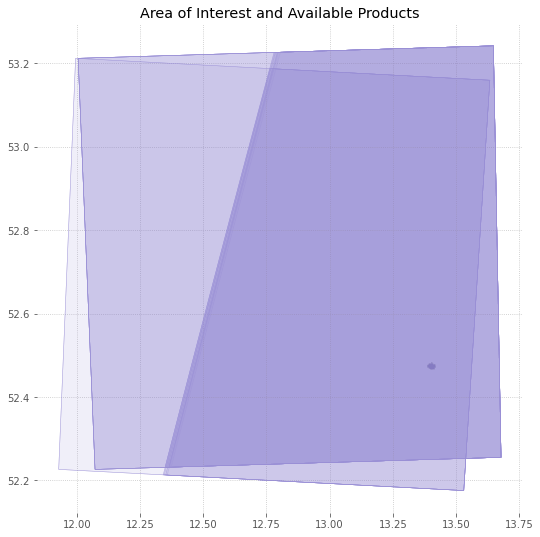

In [8]:
from sentinel_helpers import plot_downloaded_products

deduped = products_gdf.drop_duplicates(subset='beginposition', keep='first')
plot_downloaded_products(deduped, tempelhofer_feld, figsize=(9,9), alpha=0.05)

The Tempelhofer Feld is the dark spot towards the bottom right area of the plot.

Because the query has been restricted by a low acceptable cloud coverage, the distribution of returned products should return fewer products during winter:

<AxesSubplot:xlabel='week'>

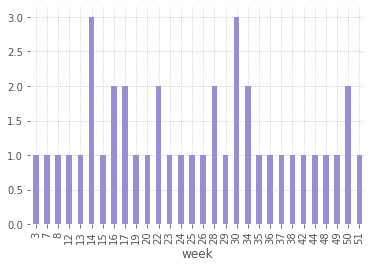

In [9]:
captured_at = deduped['beginposition'].astype('datetime64')
captured_at.groupby(captured_at.dt.isocalendar().week).count().plot(kind='bar')

### Data Retrieval

In [13]:
for uuid in tqdm(deduped['uuid'].values):
    api.download(uuid, directory_path=base_path)

Product 6c9cbc5d-d524-4705-b548-cc0641f45bfa is not online. Triggering retrieval from long term archive.
Product 5805bcbc-04d9-4c46-a26d-6471655cba13 is not online. Triggering retrieval from long term archive.
Product b1957288-84b8-4257-8a53-42ee90a34f9e is not online. Triggering retrieval from long term archive.
Product 338fb5ea-7887-40ff-b805-91f5cd25e267 is not online. Triggering retrieval from long term archive.


For the NDVI we need bands 4 and 8:

In [20]:
product_path = next(base_path.glob(deduped.iloc[0]['title'] + '*'))
b04_path, b08_path = sentinel_helpers.scihub_band_paths(product_path, ['B04', 'B08'], '10m')
b04_path, b08_path

(PosixPath('zip+file:/home/jovyan/sources/resources/tempelhofer_feld/S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_20191220T115219.zip!/S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_20191220T115219.SAFE/GRANULE/L2A_T33UUU_A023471_20191220T101426/IMG_DATA/R10m/T33UUU_20191220T101431_B04_10m.jp2'),
 PosixPath('zip+file:/home/jovyan/sources/resources/tempelhofer_feld/S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_20191220T115219.zip!/S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_20191220T115219.SAFE/GRANULE/L2A_T33UUU_A023471_20191220T101426/IMG_DATA/R10m/T33UUU_20191220T101431_B08_10m.jp2'))

**TODO** We need to do three things:

- Reproject the image into our target geometry
- Create a subset, where [this content on the rasterio homepage](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html) may help
- Make sure to mask clouds or keep the cloud mask somewhere ← **!!!TBD!!!**

In [21]:
ndvi_path = base_path / 'ndvi'
ndvi_path.mkdir(exist_ok=True, parents=True)

In [23]:
cloud_mask = sentinel_helpers.scihub_cloud_mask(product_path)

The finally helpful tip for clipping came from [this website](https://automating-gis-processes.github.io/CSC/notebooks/L5/clipping-raster.html).

**TODO** Make sure that we are using the correct range here.

CPU times: user 1.56 s, sys: 0 ns, total: 1.56 s
Wall time: 638 ms


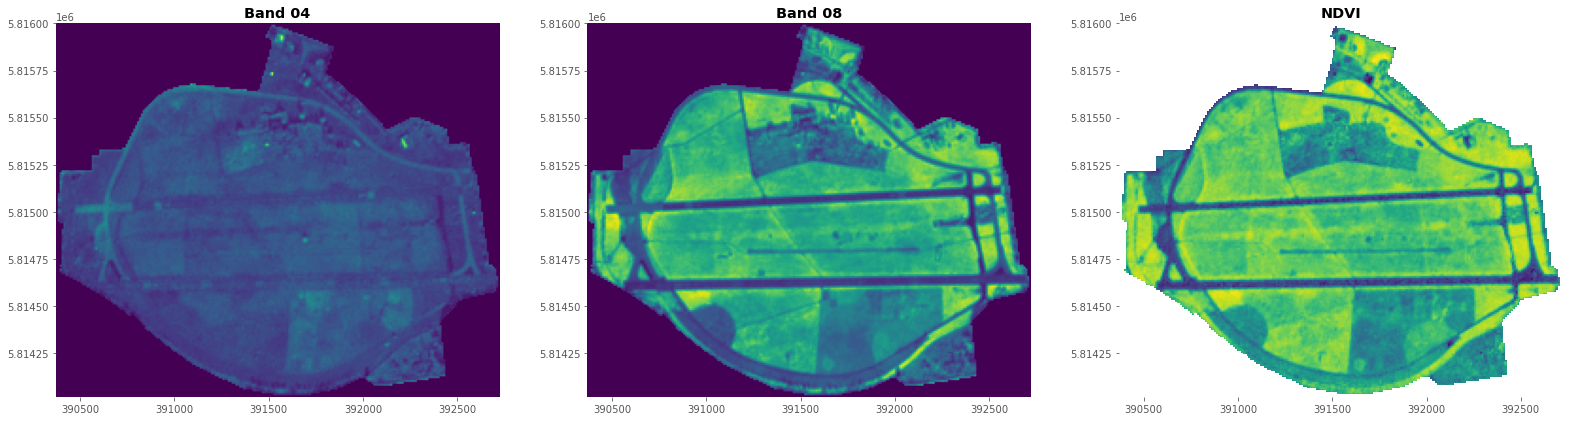

In [29]:
%%time

import matplotlib.pyplot as plt
import numpy as np
import rasterio as r
import rasterio.mask
import rasterio.plot as rplt

def normalize(v):
    return (np.clip(v, 0, 10_000) / 10_000).astype('f4') # ← four-byte-float / float32

with r.open(b04_path, 'r') as b04, r.open(b08_path, 'r') as b08:
    # we want to only write the bare minimum data necessary to disk
    out_meta = b04.meta.copy()
    
    # we reproject the geojson file we fetched above and convert it so that rasterio
    # can use it as a mask; we subtract the cloud mask
    mask = (tempelhofer_feld.to_crs(out_meta['crs']).iloc[0].geometry - cloud_mask)
    miny, minx, maxy, maxx = mask.bounds
    
    # update the dimensions and save as geotiff, not jp2
    out_meta.update({
        'width': maxx - minx,
        'height': maxy - miny,
        'driver': 'GTiff',
        'dtype': 'float32'
    })    
    out_name = Path(b04_path).name.replace('B04', 'NDVI').replace('.jp2', '.tif')
    
    output_path = ndvi_path / out_name
    with r.open(output_path, 'w+', **out_meta) as dst:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27,9))
        
        # hide background grid in plot
        ax1.grid(False)
        ax2.grid(False)
        ax3.grid(False)
        
        # we take only the part out of our source raster that we actually need
        # crop=True clips off the borders
        b04, transform_b04 = rasterio.mask.mask(b04, shapes=[mask], crop=True)
        b08, _ = rasterio.mask.mask(b08, shapes=[mask], crop=True) # we ignore the returned transform because it's identical to the previous one

        b04 = normalize(b04)
        b08 = normalize(b08)
        
        # we want to be able to ignore divide by zero errors so the formula is nicer to write
        np.seterr(divide='ignore', invalid='ignore')
        ndvi = (b08 - b04) / (b08 + b04)
       
        # uncomment the following line to see if we calculated the index correctly
        rplt.show(b04, transform=transform_b04, ax=ax1, title='Band 04')
        rplt.show(b08, transform=transform_b04, ax=ax2, title='Band 08')
        rplt.show(ndvi, transform=transform_b04, ax=ax3, title='NDVI')
        
        dst.write(ndvi)